In [2]:
!pip install comet_ml
!pip install albumentations
!pip install opencv-python
!pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.1/727.1 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 72.6 MB/s eta 0:00:00:00:01
  Attempting uninstall: python-box
    Found existing installation: python-box 7.3.2
    Uninstalling python-box-7.3.2:
      Successfully uninstalled python-box-7.3.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm


# --------------------------------------------
# Residual Block with optional upsampling
# --------------------------------------------
class ResidualBlockTranspose(nn.Module):
    def __init__(self, in_channels, out_channels, upsample=False):
        super().__init__()
        self.upsample = upsample

        self.conv1 = nn.ConvTranspose2d(
            in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1
        ) if upsample else nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        if upsample or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=1, stride=2, output_padding=1)
                if upsample else nn.Conv2d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return self.relu(out + identity)


# --------------------------------------------
# Encoder using timm (ResNet)
# --------------------------------------------
class ResNetEncoder(nn.Module):
    def __init__(self, model_name="resnet18", pretrained=True):
        super().__init__()
        self.encoder = timm.create_model(model_name, pretrained=pretrained, features_only=True)
        self.out_channels = self.encoder.feature_info[-1]['num_chs']

    def forward(self, x):
        # Only return last feature map
        return self.encoder(x)[-1]  # e.g. shape (B, 512, 16, 16) for 512×512 input


# --------------------------------------------
# Decoder: Upsample back to 512×512
# --------------------------------------------
class ResNetDecoder(nn.Module):
    def __init__(self, in_channels, out_channels=3):
        super().__init__()
        self.decoder = nn.Sequential(
            ResidualBlockTranspose(in_channels, 256, upsample=True),  # 16 → 32
            ResidualBlockTranspose(256, 128, upsample=True),          # 32 → 64
            ResidualBlockTranspose(128, 64, upsample=True),           # 64 → 128
            ResidualBlockTranspose(64, 32, upsample=True),            # 128 → 256
            ResidualBlockTranspose(32, 16, upsample=True),            # 256 → 512
            nn.Conv2d(16, out_channels, kernel_size=3, padding=1),
            nn.Sigmoid()  # assume input is in [0, 1]
        )

    def forward(self, x):
        return self.decoder(x)


# --------------------------------------------
# Autoencoder model
# --------------------------------------------
class ResNetAutoencoder(nn.Module):
    def __init__(self, model_name="resnet18"):
        super().__init__()
        self.encoder = ResNetEncoder(model_name)
        self.decoder = ResNetDecoder(self.encoder.out_channels)

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out




In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = SimpleCNN(num_classes).to(device)
resnet_autoencoder = ResNetAutoencoder("resnet18").to(device)
checkpoint = torch.load("/kaggle/input/resnet_auto/pytorch/default/1/best_autoencoder.pt", weights_only=True)
resnet_autoencoder.load_state_dict(checkpoint["model_state_dict"])
resnet_encoder = resnet_autoencoder.encoder.encoder

class ResNetFeatureOnlyClassifier(nn.Module):
    def __init__(self, base_model, num_classes=1, dropout_rate=0.5):
        super().__init__()

        # Get encoder with intermediate features
        self.encoder = base_model
        # Feature info has shape info per stage
        feature_channels = self.encoder.feature_info[-1]['num_chs']  # channels of last stage

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(feature_channels, num_classes)

    def forward(self, x):
        features = self.encoder(x)       # list of 5 feature maps
        x = features[-1]                 # use the last stage's output
        x = self.pool(x)                 # (B, C, 1, 1)
        x = torch.flatten(x, 1)          # (B, C)
        x = self.dropout(x)
        x = self.fc(x)
        return x
model = ResNetFeatureOnlyClassifier(resnet_encoder).to(device)
# checkpoint = torch.load("/kaggle/input/resnet18/pytorch/default/1/checkpoint_37", weights_only=True)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
val = model(torch.rand(4, 3, 512, 512).to(device))
print(val.shape)
print(model)

torch.Size([4, 1])
ResNetFeatureOnlyClassifier(
  (encoder): FeatureListNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act1): ReLU(inplace=True)
        (aa): Identity()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, k

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader,Subset
from PIL import Image
import pandas as pd
import os
import numpy as np
from torch.utils.data import WeightedRandomSampler, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from comet_ml import start
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import timm 
from torch.optim.lr_scheduler import LambdaLR

# Custom Dataset
class ImageDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        # self.data = pd.read_csv(csv_file, nrows=100)
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = "/kaggle/input/diabetic-retinopathyresized-512x512/train_images_resized_512/"+self.data.iloc[idx, 0]+".jpeg"
        label = int(self.data.iloc[idx, 1])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        return image, label
        
class TransformSubset(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, idx):
        x, y = self.subset[idx]
        if self.transform:
            x = self.transform(image=x)["image"]
        return x, y

    def __len__(self):
        return len(self.subset)



# def get_timm_model(model_name,num_classes):
#     # model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
#     model = timm.create_model(model_name, pretrained=True)
#     model.classifier = nn.Linear(model.classifier.in_features, num_classes)
#     return model

def get_timm_model(model_name, num_classes, dropout_rate=0.5,new_model=None):
    
    if not new_model:
        model = timm.create_model(model_name, pretrained=True)
    else:
        model = new_model
        
    # Inspect classifier name depending on model
    if hasattr(model, 'classifier'):  # For models like EfficientNet
        print("WORKINGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG")
        in_features = model.classifier.in_features
        model.classifier = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(in_features, num_classes)
        )
        
    elif hasattr(model, 'fc'):  # For models like ResNet
        in_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(in_features, num_classes)
        )

    elif hasattr(model, 'head'):  # Some models use `head`
        in_features = model.head.in_features
        model.head = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(in_features, num_classes)
        )
    
    else:
        raise ValueError("Unknown classifier layer in the model.")
    
    return model


# Training function
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print("LOSS:",loss)
    print(f"Training loss: {loss.item():.4f}")

def validate(model, dataloader, criterion, device,scheduler=None):
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(dtype=torch.float32)
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)  # total loss for batch

            # preds = torch.argmax(outputs, dim=1)
            # Convert MSE floats to integer predictions
            outputs[outputs < 0.5] = 0
            outputs[(outputs >= 0.5) & (outputs < 1.5)] = 1
            outputs[(outputs >= 1.5) & (outputs < 2.5)] = 2
            outputs[(outputs >= 2.5) & (outputs < 3.5)] = 3
            outputs[(outputs >= 3.5) & (outputs < 10000000)] = 4
            outputs = outputs.squeeze(1)
            all_preds.extend(outputs.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
            
    avg_loss = val_loss / len(dataloader.dataset)
    k_score = cohen_kappa_score(all_targets,all_preds,weights="quadratic")
    print("K-SCORE:",k_score)
    val_f1 = f1_score(all_targets, all_preds, average='macro', labels=list(range(5)))
    val_cm = confusion_matrix(all_targets, all_preds)
    
    # scheduler.step(avg_loss)
    return avg_loss,val_f1,val_cm,k_score  # average loss


# Define lambda function
def lr_lambda(epoch):
    if epoch <= 10:
        return 1        # use base_lr
    elif epoch >10 and epoch <= 20:
        return 0.1        # 0.1 * base_lr
    else:
        return 0.01      # 0.01 * base_lr

In [22]:
def main():
    torch.cuda.empty_cache()
    PATH = "/kaggle/working/checkpoint_"
    # Comet Experiment
    experiment = start(
      api_key="clEyXjBpSkvfrD5bYxCf3vVK9",
        
      project_name="diabetic-retinopathy_pretrained",
      workspace="neloy-sarwar",
    )

    # -------------------------------
    # Hyperparameters
    # -------------------------------
    csv_path = '/kaggle/input/diabetic-retinopathyresized-512x512/trainLabels.csv'
    num_classes = 5
    batch_size = 16
    num_epochs = 100
    learning_rate = 1e-4
    patience = 10 

    experiment.log_parameters({
        "num_classes": num_classes,
        "batch_size": batch_size,
        "num_epochs": num_epochs,
        "learning_rate": learning_rate,
        "patience": patience
    })

    # -------------------------------
    # Dataset & Dataloaders
    # -------------------------------
    # transform = transforms.Compose([
    #     transforms.ToTensor(),
    #     transforms.Normalize(mean=[0.3759, 0.2611, 0.1863],
    #                          std=[0.2525, 0.1780, 0.1291]),
    # ])

    train_transforms = A.Compose(
        [
            # A.Resize(height=256, width=256),
            A.RandomCrop(height=512, width=512),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.Blur(p=0.3),
            A.CLAHE(p=0.3),
            A.ColorJitter(p=0.3),
            # A.CoarseDropout(max_holes=12, max_height=20, max_width=20, p=0.3),
            A.Normalize(
                mean=[0.3199, 0.2240, 0.1609],
                std=[0.3020, 0.2183, 0.1741],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ]
    )

    val_transforms = A.Compose(
    [
        # A.Resize(height=256, width=256),
        A.Normalize(
                mean=[0.3199, 0.2240, 0.1609],
                std=[0.3020, 0.2183, 0.1741],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ]
    )

    # Initialize dataset
    dataset = ImageDataset(csv_path)
    
    # Perform stratified split
    labels = dataset.data['level']
    train_idx, val_idx = train_test_split(
        np.arange(len(dataset)),
        test_size=0.2,
        stratify=labels,
        random_state=42
    )
    
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)
    
    train_dataset = TransformSubset(train_subset, train_transforms)
    val_dataset = TransformSubset(val_subset, val_transforms)
    

    # Create Weighted Sampler for training set
    train_labels = labels.iloc[train_idx].values
    class_counts = np.bincount(train_labels)
    class_weights = 1. / class_counts
    sample_weights = class_weights[train_labels]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)
    print(train_dataset.transform)
    # # Dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    

    # -------------------------------
    # Model, Optimizer, Loss
    # -------------------------------
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # model = SimpleCNN(num_classes).to(device)
    # model = get_timm_model("resnet18",1,new_model = resnet_encoder.encoder).to(device)
    # criterion = nn.CrossEntropyLoss()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=5e-4)
    # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)
    # -------------------------------
    # Training Loop
    # -------------------------------
    best_train_loss = float('inf')
    best_val_loss = float('inf')
    best_train_f1 = 0.0
    patience_counter = 0

    for epoch in range(num_epochs):
        
        if patience_counter==10:
            break
            
        # print(f"\nEpoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        all_preds = []
        all_targets = []

        for batch_idx, (images, labels) in enumerate(train_loader):
            images = images.to(dtype=torch.float32)
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_loss = loss.item()
            running_loss += batch_loss * images.size(0)

            # F1 tracking
            # preds = torch.argmax(outputs, dim=1)
            preds = torch.round(outputs).squeeze().long() 
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

            # Comet logging: separate panel per epoch
            metric_name = f"batch_train_loss/epoch_{epoch}"
            # experiment.log_metric(metric_name, batch_loss, step=batch_idx)
            print(f"\nEpoch {epoch+1}/{num_epochs}  Batch {batch_idx + 1}/{len(train_loader)} - Loss: {batch_loss:.4f}")

        # Per-epoch stats
        train_loss = running_loss / len(train_loader.dataset)
        train_f1 = f1_score(all_targets, all_preds, average='macro',zero_division=0)
        cm = confusion_matrix(all_targets, all_preds)
        train_k_score = cohen_kappa_score(all_targets,all_preds,weights="quadratic")
        val_loss,val_f1,val_cm,k_score = validate(model, val_loader, criterion, device,scheduler)

        # Logging to console
        print(f"Epoch Train Loss: {train_loss:.4f}")
        print(f"Epoch Val Loss  : {val_loss:.4f}")
        print(f"Epoch Train F1  : {train_f1:.4f}")

        # Log to Comet
        experiment.log_metric("train_loss", train_loss, step=epoch)
        experiment.log_metric("val_loss", val_loss, step=epoch)
        experiment.log_metric("val_f1", val_f1, step=epoch)
        experiment.log_metric("train_f1", train_f1, step=epoch)
        experiment.log_metric("learning_rate", optimizer.param_groups[0]['lr'], step=epoch)
        experiment.log_metric("val_k_score", k_score, step=epoch)
        experiment.log_metric("train_k_score", train_k_score, step=epoch)
        # Create a heatmap with seaborn
        plt.figure(figsize=(6, 4))
        sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues', cbar=True)
        
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        image_path = f"val_confusion_matrix_epoch.png"
        # Save figure as PNG file

        
        # Track best metrics
        if train_loss < best_train_loss:
            best_train_loss = train_loss
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, PATH+str(epoch))
            # torch.save(model.state_dict(), f"best_model.pth")
            plt.savefig(image_path)

            experiment.log_image(image_path)
            # experiment.log_asset("best_model.pth")
            print("✅ Best model saved.")
        else:
            patience_counter+=1
        
        if train_f1 > best_train_f1:
            best_train_f1 = train_f1



    # Log best metrics
    experiment.log_metric("best_train_loss", best_train_loss)
    experiment.log_metric("best_val_loss", best_val_loss)
    experiment.log_metric("best_train_f1", best_train_f1)
    experiment.end()
    print("🎉 Training finished.")

COMET INFO: An experiment with the same configuration options is already running and will be reused.


Compose([
  RandomCrop(p=1.0, height=512, width=512, pad_if_needed=False, border_mode=0, fill=0.0, fill_mask=0.0, pad_position='center'),
  HorizontalFlip(p=0.5),
  VerticalFlip(p=0.5),
  RandomRotate90(p=0.5),
  Blur(p=0.3, blur_limit=(3, 7)),
  CLAHE(p=0.3, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8)),
  ColorJitter(p=0.3, brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.5, 0.5)),
  Normalize(p=1.0, mean=(0.3199, 0.224, 0.1609), std=(0.302, 0.2183, 0.1741), max_pixel_value=255.0, normalization='standard'),
  ToTensorV2(p=1.0, transpose_mask=False),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 1/50  Batch 1/5 - Loss: 1.2832
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMI

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


✅ Best model saved.
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 2/50  Batch 1/5 - Loss: 0.8309
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 2/50  Batch 2/5 - Loss: 1.3793
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 2/50  Batch 3/5 - Loss: 0.8292
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 2/50  Batch 4/5 - Loss: 0.3

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 3/50  Batch 1/5 - Loss: 0.3680
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 3/50  Batch 2/5 - Loss: 0.4696
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 3/50  Batch 3/5 - Loss: 1.2771
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 3/50  Batch 4/5 - Loss: 0.2627
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRA

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


✅ Best model saved.
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 4/50  Batch 1/5 - Loss: 1.4473
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 4/50  Batch 2/5 - Loss: 1.0872
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 4/50  Batch 3/5 - Loss: 0.4157
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 4/50  Batch 4/5 - Loss: 0.3

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 5/50  Batch 1/5 - Loss: 0.2374
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 5/50  Batch 2/5 - Loss: 0.3366
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 5/50  Batch 3/5 - Loss: 0.4321
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 5/50  Batch 4/5 - Loss: 0.7980
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRA

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 6/50  Batch 1/5 - Loss: 0.2324
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 6/50  Batch 2/5 - Loss: 0.7650
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 6/50  Batch 3/5 - Loss: 0.3585
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 6/50  Batch 4/5 - Loss: 0.5290
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRA

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 7/50  Batch 1/5 - Loss: 0.3091
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 7/50  Batch 2/5 - Loss: 0.2237
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 7/50  Batch 3/5 - Loss: 0.9756
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 7/50  Batch 4/5 - Loss: 0.3779
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRA

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


✅ Best model saved.
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 8/50  Batch 1/5 - Loss: 0.4820
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 8/50  Batch 2/5 - Loss: 0.3124
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 8/50  Batch 3/5 - Loss: 0.4672
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 8/50  Batch 4/5 - Loss: 0.3

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


✅ Best model saved.
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 9/50  Batch 1/5 - Loss: 0.4392
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 9/50  Batch 2/5 - Loss: 0.1932
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 9/50  Batch 3/5 - Loss: 0.2602
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 9/50  Batch 4/5 - Loss: 0.1

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


✅ Best model saved.
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 10/50  Batch 1/5 - Loss: 0.2148
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 10/50  Batch 2/5 - Loss: 0.3682
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 10/50  Batch 3/5 - Loss: 0.1750
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 10/50  Batch 4/5 - Loss:

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


✅ Best model saved.
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 11/50  Batch 1/5 - Loss: 0.3160
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 11/50  Batch 2/5 - Loss: 0.2748
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 11/50  Batch 3/5 - Loss: 0.2043
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 11/50  Batch 4/5 - Loss:

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


✅ Best model saved.
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 12/50  Batch 1/5 - Loss: 0.3672
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 12/50  Batch 2/5 - Loss: 0.3518
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 12/50  Batch 3/5 - Loss: 0.6631
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 12/50  Batch 4/5 - Loss:

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


✅ Best model saved.
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 13/50  Batch 1/5 - Loss: 0.6139
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 13/50  Batch 2/5 - Loss: 0.3907
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 13/50  Batch 3/5 - Loss: 0.4006
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 13/50  Batch 4/5 - Loss:

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


✅ Best model saved.
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 14/50  Batch 1/5 - Loss: 0.2341
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 14/50  Batch 2/5 - Loss: 0.2029
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 14/50  Batch 3/5 - Loss: 0.2677
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 14/50  Batch 4/5 - Loss:

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


✅ Best model saved.
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 15/50  Batch 1/5 - Loss: 0.2538
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 15/50  Batch 2/5 - Loss: 0.1915
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 15/50  Batch 3/5 - Loss: 0.1997
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 15/50  Batch 4/5 - Loss:

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 16/50  Batch 1/5 - Loss: 0.0929
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 16/50  Batch 2/5 - Loss: 0.2843
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 16/50  Batch 3/5 - Loss: 0.2731
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 16/50  Batch 4/5 - Loss: 0.3528
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


TRANSFORMING

Epoch 17/50  Batch 1/5 - Loss: 0.2620
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 17/50  Batch 2/5 - Loss: 0.1775
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING

Epoch 17/50  Batch 3/5 - Loss: 0.2030
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING
TRANSFORMING


KeyboardInterrupt: 

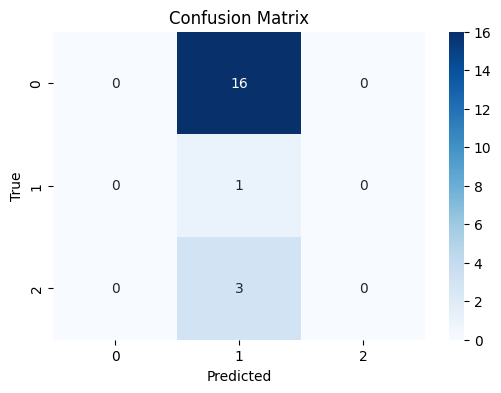

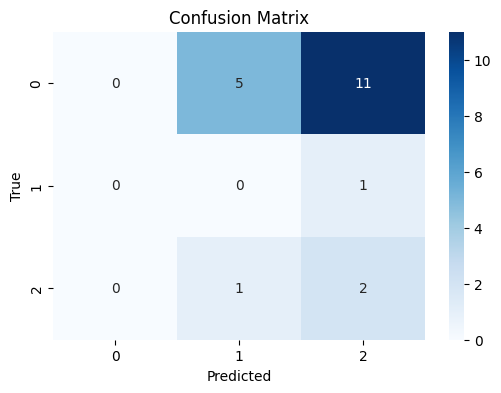

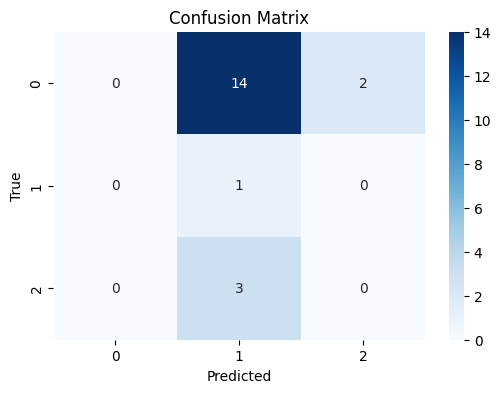

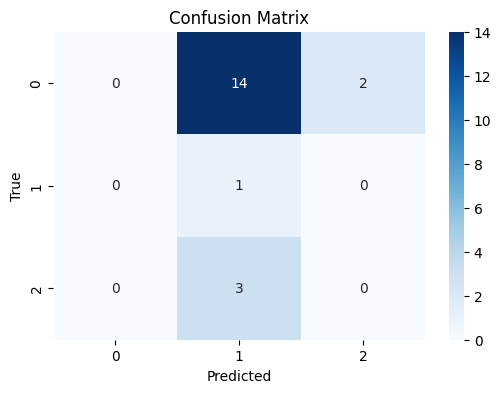

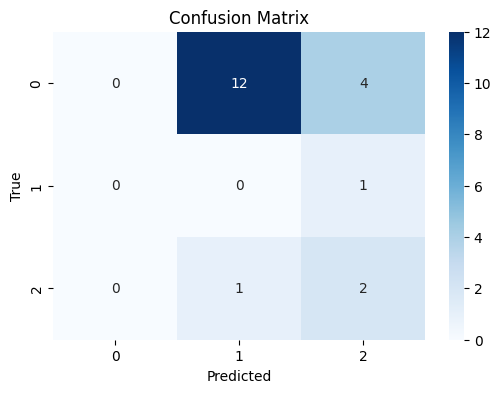

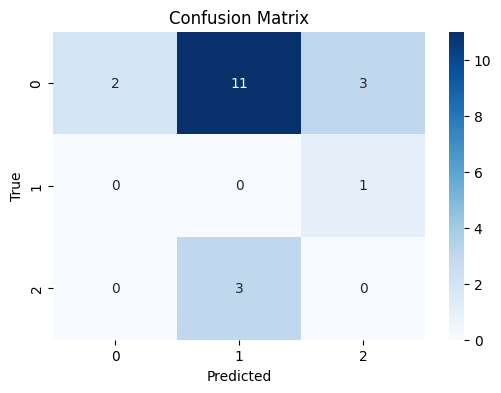

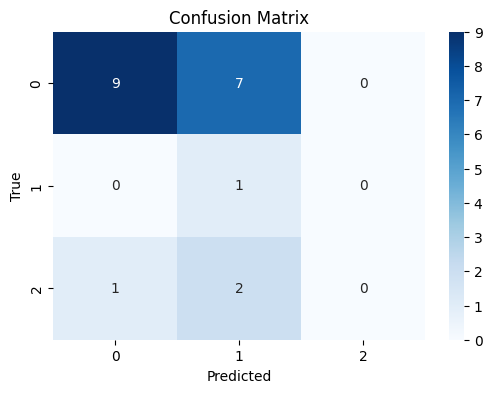

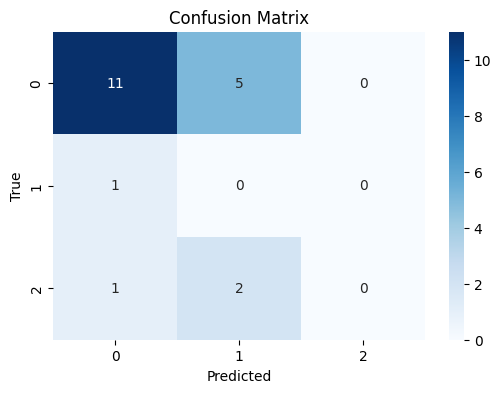

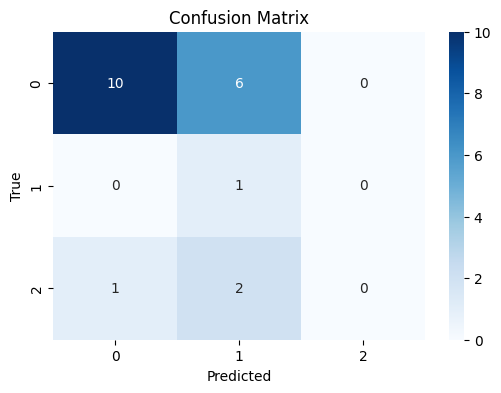

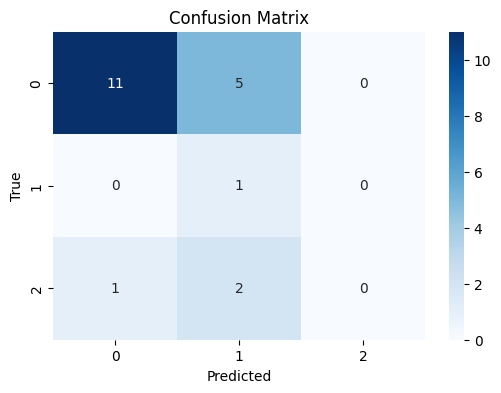

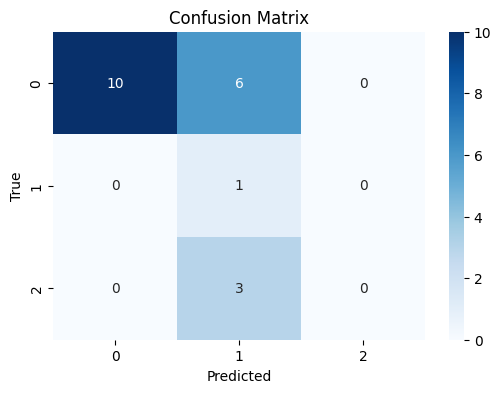

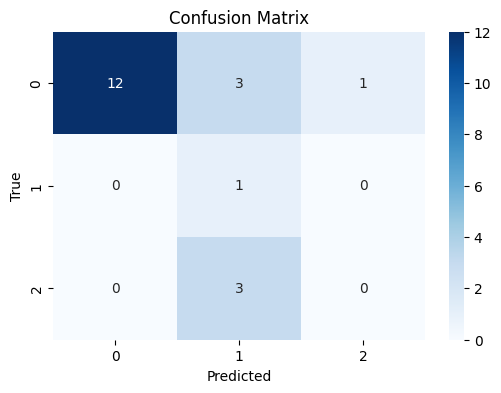

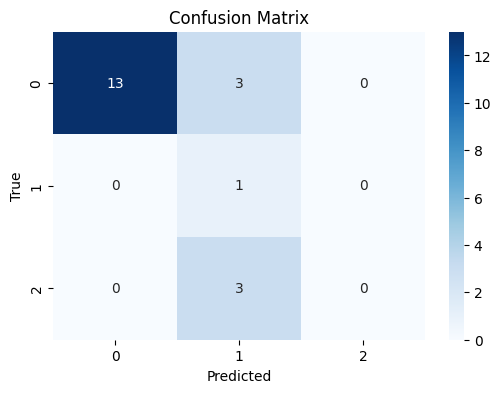

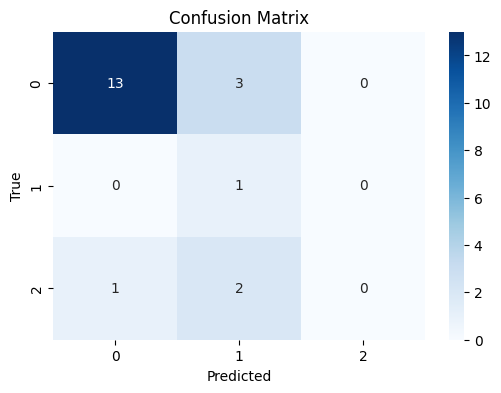

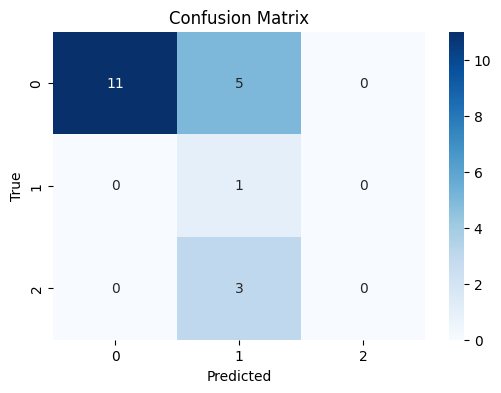

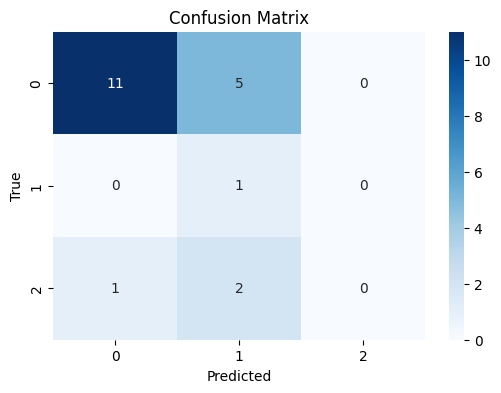

In [23]:
main()